## Ensemble Methods

Ensemble methods are meta-algorithms that combine several machine learning techniques into one predictive model in order to decrease variance (bagging), bias (boosting), or improve predictions (stacking). Ensemble methods can be divided into two groups: *sequential* ensemble methods where the base learners are generated sequentially (e.g. AdaBoost) and *parallel* ensemble methods where the base learners are generated in parallel (e.g. Random Forest). The basic motivation of sequential methods is to exploit the dependence between the base learners since the overall performance can be boosted by weighing previously mislabeled examples with higher weight.  The basic motivation of parallel methods is to exploit independence between the base learners since the error can be reduced dramatically by averaging. 

Most ensemble methods use a single base learning algorithm to produce homogeneous base learners, i.e. learners of the same type leading to *homogeneous ensembles*. There are also some methods that use heterogeneous learners, i.e. learners of different types, leading to *heterogeneous ensembles*. In order for ensemble methods to be more accurate than any of its individual members the base learners have to be as accurate as possible and as diverse as possible.


### Bagging

Bagging stands for bootstrap aggregation. One way to reduce the variance of an estimate is to average together multiple estimates. For example, we can train $M$ different trees $f_m$ on different subsets of the data (chosen randomly with replacement) and compute the ensemble:
\begin{equation}
   f(x) = \frac{1}{M}\sum_{m=1}^{M}f_m(x) 
\end{equation}

Bagging uses bootstrap sampling to obtain the data subsets for training the base learners. For aggregating the outputs of base learners, bagging uses voting for classification and averaging for regression.


In [12]:
%matplotlib inline

import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier

from sklearn.ensemble import BaggingClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

np.random.seed(0)

In [13]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
clf1 = DecisionTreeClassifier(criterion='entropy', max_depth=1)
clf2 = KNeighborsClassifier(n_neighbors=1)    

bagging1 = BaggingClassifier(base_estimator=clf1, n_estimators=10, max_samples=0.8, max_features=0.8)
bagging2 = BaggingClassifier(base_estimator=clf2, n_estimators=10, max_samples=0.8, max_features=0.8)

Accuracy: 0.63 (+/- 0.02) [Decision Tree]
Accuracy: 0.70 (+/- 0.02) [K-NN]
Accuracy: 0.67 (+/- 0.03) [Bagging Tree]
Accuracy: 0.61 (+/- 0.02) [Bagging K-NN]


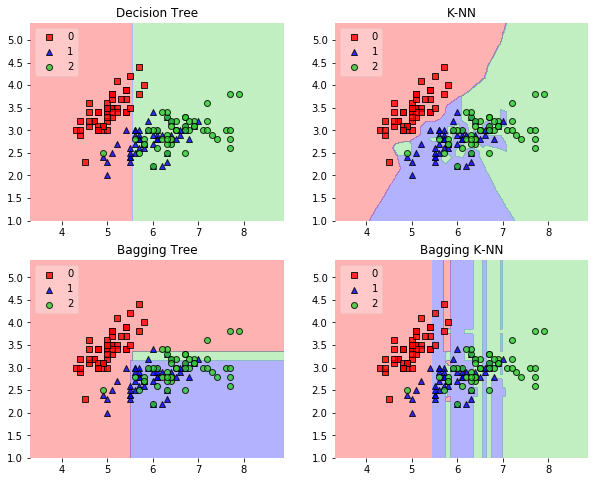

In [6]:
label = ['Decision Tree', 'K-NN', 'Bagging Tree', 'Bagging K-NN']
clf_list = [clf1, clf2, bagging1, bagging2]

fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for clf, label, grd in zip(clf_list, label, grid):        
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
        
    clf.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=clf, legend=2)
    plt.title(label)

plt.show()

The figure above shows the decision boundary of a decision tree and k-NN classifiers along with their bagging ensembles applied to the Iris dataset. The decision tree shows axes parallel boundaries while the $k=1$ nearest neighbors fits closely to the data points. The bagging ensembles were trained using $10$ base estimators with $0.8$ subsampling of training data and $0.8$ subsampling of features. The decision tree bagging ensemble achieved higher accuracy in comparison to k-NN bagging ensemble because k-NN are less sensitive to perturbation on training samples and therefore they are called *stable learners*. Combining stable learners is less advantageous since the ensemble will not help improve generalization performance.

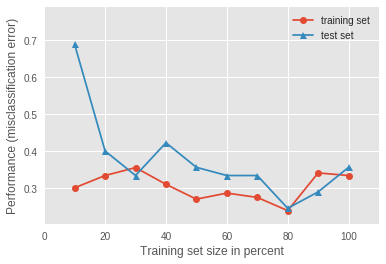

In [16]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, bagging1, print_model=False, style='ggplot')
plt.show()

The figure above shows learning curves for the bagging tree ensemble. We can see an average error of $0.3$ on the training data and a U-shaped error curve for the testing data. The smallest gap between training and test errors occurs at around $80\%$ of the training set size.

In [18]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:    
    bg_clf = BaggingClassifier(base_estimator=clf1, n_estimators=n_est, max_samples=0.8, max_features=0.8)
    scores = cross_val_score(bg_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

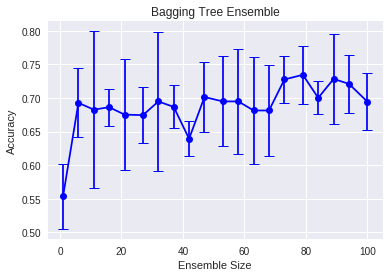

In [19]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('Bagging Tree Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble. Based on cross-validation results, we can see the accuracy increases until approximately $10$ base estimators and then plateaus afterwards. Thus, adding base estimators beyond $10$ only increases computational complexity without accuracy gains for the Iris dataset.

A commonly used class of ensemble algorithms are forests of randomized trees. In **random forests**, each tree in the ensemble is built from a sample drawn with replacement (i.e. a bootstrap sample) from the training set. In addition, instead of using all the features, a random subset of features is selected further randomizing the tree. As a result, the bias of the forest increases slightly but due to averaging of less correlated trees, its variance decreases resulting in an overall better model.

In **extremely randomized trees** algorithm randomness goes one step further: the splitting thresholds are randomized. Instead of looking for the most discriminative threshold, thresholds are drawn at random for each candidate feature and the best of these randomly-generated thresholds is picked as the splitting rule. This usually allows to reduce the variance of the model a bit more, at the expense of a slightly greater increase in bias.

### Boosting

Boosting refers to a family of algorithms that are able to convert weak learners to strong learners. The main principle of boosting is to fit a sequence of weak learners (models that are only slightly better than random guessing, such as small decision trees) to weighted versions of the data, where more weight is given to examples that were mis-classified by earlier rounds. The predictions are then combined through a weighted majority vote (classification) or a weighted sum (regression) to produce the final prediction. The principal difference between boosting and the committee methods such as bagging is that base learners are trained in sequence on a weighted version of the data.   

In [17]:
import itertools
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import AdaBoostClassifier
from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

In [18]:
iris = datasets.load_iris()
X, y = iris.data[:, 0:2], iris.target
    
#XOR dataset
#X = np.random.randn(200, 2)
#y = np.array(map(int,np.logical_xor(X[:, 0] > 0, X[:, 1] > 0)))
    
clf = DecisionTreeClassifier(criterion='entropy', max_depth=1)

num_est = [1, 2, 3, 10]
label = ['AdaBoost (n_est=1)', 'AdaBoost (n_est=2)', 'AdaBoost (n_est=3)', 'AdaBoost (n_est=10)']

Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=1)]
Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=2)]
Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=3)]
Accuracy: 0.63 (+/- 0.02) [AdaBoost (n_est=10)]


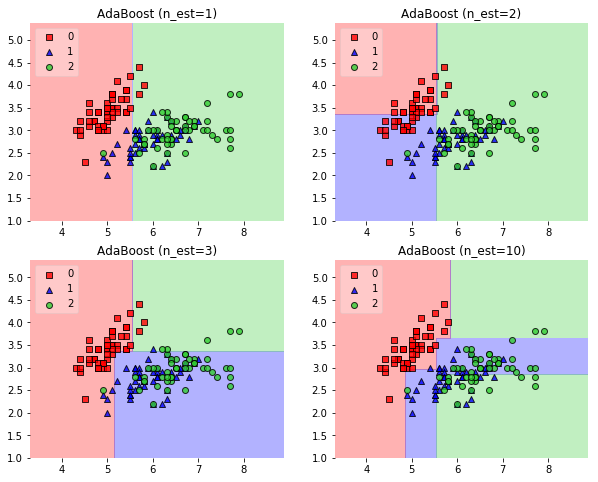

In [19]:
fig = plt.figure(figsize=(10, 8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

for n_est, label, grd in zip(num_est, label, grid):     
    scores = cross_val_score(clf, X, y, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    
    boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)   
    boosting.fit(X, y)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X, y=y, clf=boosting, legend=2)
    plt.title(label)

plt.show()

The AdaBoost algorithm is illustrated in the figure above. Each base learner consists of a decision tree with depth $1$, thus classifying the data based on a feature threshold that partitions the space into two regions separated by a linear decision surface that is parallel to one of the axes.

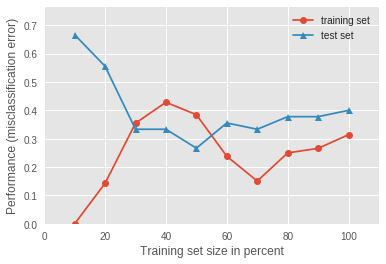

In [27]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

boosting = AdaBoostClassifier(base_estimator=clf, n_estimators=10)
        
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, boosting, print_model=False, style='ggplot')
plt.show()

In [28]:
#Ensemble Size
num_est = map(int, np.linspace(1,100,20))
bg_clf_cv_mean = []
bg_clf_cv_std = []
for n_est in num_est:
    ada_clf = AdaBoostClassifier(base_estimator=clf, n_estimators=n_est)
    scores = cross_val_score(ada_clf, X, y, cv=3, scoring='accuracy')
    bg_clf_cv_mean.append(scores.mean())
    bg_clf_cv_std.append(scores.std())

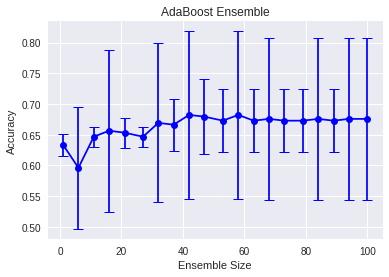

In [29]:
plt.figure()
(_, caps, _) = plt.errorbar(num_est, bg_clf_cv_mean, yerr=bg_clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.ylabel('Accuracy'); plt.xlabel('Ensemble Size'); plt.title('AdaBoost Ensemble');
plt.show()

The figure above shows how the test accuracy improves with the size of the ensemble.

**Gradient Tree Boosting** is a generalization of boosting to arbitrary differentiable loss functions. It can be used for both regression and classification problems.

### Stacking

Stacking is an ensemble learning technique that combines multiple classification or regression models via a meta-classifier or a meta-regressor. The base level models are trained based on complete training set then the meta-model is trained on the outputs of base level model as features. The base level often consists of different learning algorithms and therefore stacking ensembles are often heterogeneous.

In [1]:
import itertools
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from sklearn import datasets

from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB 
from sklearn.ensemble import RandomForestClassifier
from mlxtend.classifier import StackingClassifier

from sklearn.model_selection import cross_val_score, train_test_split

from mlxtend.plotting import plot_learning_curves
from mlxtend.plotting import plot_decision_regions

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

In [2]:
iris = datasets.load_iris()
X, y = iris.data[:, 1:3], iris.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

clf1 = KNeighborsClassifier(n_neighbors=1)
clf2 = RandomForestClassifier(random_state=1)
rf = RandomForestClassifier(random_state=1, min_samples_leaf=10)
rf = RandomForestClassifier(random_state=1)
clf3 = GaussianNB()
lr = LogisticRegression()
sclf = StackingClassifier(classifiers=[clf1, clf2, clf3], 
                          meta_classifier=lr)

In [3]:
X.shape, y.shape, X_train.shape,  y_train.shape, X_test.shape, y_test.shape

((150, 2), (150,), (100, 2), (100,), (50, 2), (50,))

train acc 0.98
test acc 0.94
train acc 0.98
test acc 0.94
train acc 0.94
test acc 0.98
train acc 0.94
test acc 0.98


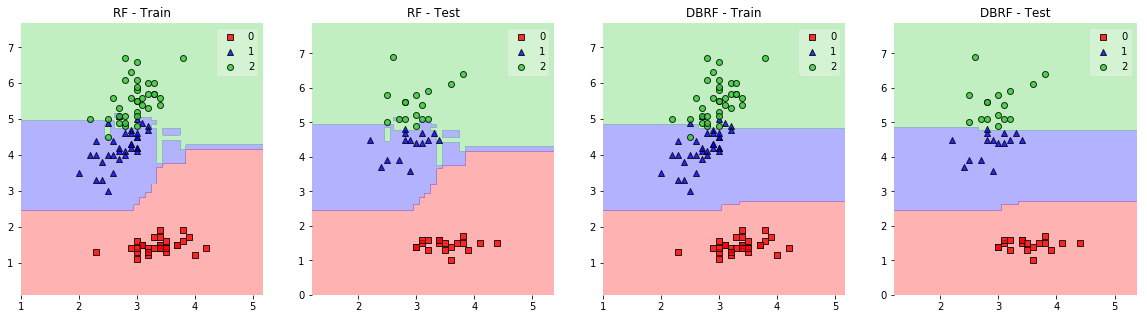

In [11]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
# clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(20,5))
gs = gridspec.GridSpec(1, 4)
   
####
# scores = cross_val_score(clf2, X_train, y_train, cv=3, scoring='accuracy')
# print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), 'Random Forest'))
# clf_cv_mean.append(scores.mean())
# clf_cv_std.append(scores.std())

rf.fit(X_train, y_train)
acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print("train acc", acc)
acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print("test acc", acc)
ax = plt.subplot(gs[0, 0])
fig = plot_decision_regions(X=X_train, y=y_train, clf=rf)
plt.title('RF - Train')

####
# scores = cross_val_score(clf2, X_train, y_train, cv=3, scoring='accuracy')
# print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), 'Random Forest'))
# clf_cv_mean.append(scores.mean())
# clf_cv_std.append(scores.std())

rf.fit(X_train, y_train)
acc = accuracy_score(y_true=y_train, y_pred=rf.predict(X_train))
print("train acc", acc)
acc = accuracy_score(y_true=y_test, y_pred=rf.predict(X_test))
print("test acc", acc)
ax = plt.subplot(gs[0, 1])
fig = plot_decision_regions(X=X_test, y=y_test, clf=rf)
plt.title('RF - Test')

####
df.fit(X_train, y_train)
acc = accuracy_score(y_true=y_train, y_pred=df.predict(X_train))
print("train acc", acc)
acc = accuracy_score(y_true=y_test, y_pred=df.predict(X_test))
print("test acc", acc)
ax = plt.subplot(gs[0, 2])
fig = plot_decision_regions(X=X_train, y=y_train, clf=df)
plt.title('DBRF - Train')

####
df.fit(X_train, y_train)
acc = accuracy_score(y_true=y_train, y_pred=df.predict(X_train))
print("train acc", acc)
acc = accuracy_score(y_true=y_test, y_pred=df.predict(X_test))
print("test acc", acc)
ax = plt.subplot(gs[0, 3])
fig = plot_decision_regions(X=X_test, y=y_test, clf=df)
plt.title('DBRF - Test')

plt.savefig("./logs/images/ensemble0421.pdf", bbox_inches='tight')
plt.show()

In [5]:
pass_data_rate_lt = [i[1] for i in a_list]

In [38]:
pass_data_rate_lt

[0.0,
 0.14691972237577544,
 0.16467047478656102,
 0.17290092746145813,
 0.17904305632332165,
 0.18297401879491432,
 0.18684355997788835,
 0.18880904121368466,
 0.1909587863153369,
 0.1931085314169891,
 0.19409127203488727,
 0.1953811190958786,
 0.1974694429089122,
 0.19808365579509854,
 0.19912781770161533,
 0.20097045636017438,
 0.20183035440083527,
 0.2025674098642589,
 0.2031202014618266,
 0.20385725692525022,
 0.20428720594558067,
 0.20459431238867384,
 0.20526994656347883,
 0.20569989558380927,
 0.20649837233585153,
 0.20711258522203788,
 0.20741969166513105,
 0.20778821939684286,
 0.20791106197408013,
 0.20834101099441057,
 0.20858669614888511,
 0.20901664516921556,
 0.209446594189546,
 0.2096308580554019,
 0.20987654320987645,
 0.21036791351882553,
 0.2108592838277746,
 0.21110496898224915,
 0.21159633929119823,
 0.21202628831152867,
 0.21245623733185912,
 0.21270192248633366,
 0.21282476506357093,
 0.21307045021804547,
 0.2131318715066641,
 0.2131318715066641,
 0.2134389779497

In [7]:
test_loss_lt = [i[1] for i in a_list]
test_loss_lt[27] = 0.86616301209999391
test_loss_lt[28] = 0.86636605859590929
test_loss_lt[29] = 0.86606605859590929
test_loss_lt[30] = 0.86617874823413801

In [39]:
test_loss_lt

[0.8568883975185799,
 0.8645660585959093,
 0.8654873779251888,
 0.8646274798845279,
 0.8649345863276211,
 0.8645046373072907,
 0.8638904244211043,
 0.8647503224617652,
 0.8648731650390025,
 0.8649960076162397,
 0.8648117437503838,
 0.8653645353479515,
 0.8646889011731466,
 0.8649960076162397,
 0.8649345863276211,
 0.864443216018672,
 0.8645046373072907,
 0.8649345863276211,
 0.8649960076162397,
 0.8651802714820956,
 0.865118850193477,
 0.865118850193477,
 0.8651802714820956,
 0.8648117437503838,
 0.865978748234138,
 0.8661630120999939,
 0.8651802714820956,
 0.8661630120999939,
 0.8663660585959093,
 0.8660660585959092,
 0.866178748234138,
 0.8651802714820956,
 0.8648731650390025,
 0.8654873779251888,
 0.865978748234138,
 0.8646274798845279,
 0.865978748234138,
 0.865118850193477,
 0.8653645353479515,
 0.8645660585959093,
 0.8649345863276211,
 0.8656102205024261,
 0.8647503224617652,
 0.8645046373072907,
 0.8641975308641975,
 0.8647503224617652,
 0.8649960076162397,
 0.8647503224617652,


In [40]:
vaild_loss_lt

[0.857375387733792,
 0.8617978563311938,
 0.8628113387180983,
 0.8620435490310494,
 0.862350664905869,
 0.8627806271306164,
 0.8624120880808329,
 0.8633334357052916,
 0.8633334357052916,
 0.8624427996683148,
 0.8624427996683148,
 0.8625042228432788,
 0.8628727618930623,
 0.8627192039556525,
 0.862289241730905,
 0.8623813764933509,
 0.8621663953809773,
 0.8622585301434231,
 0.8626884923681705,
 0.8626270691932066,
 0.8626577807806886,
 0.8627192039556525,
 0.8627499155431344,
 0.8639783790424127,
 0.8628113387180983,
 0.863701974755075,
 0.8637326863425571,
 0.8635600288688923,
 0.8638356837934953,
 0.8631656460182427,
 0.8637806271306164,
 0.8624735112557969,
 0.8624735112557969,
 0.8627499155431344,
 0.8614907404563742,
 0.8628113387180983,
 0.8613986056939283,
 0.8626884923681705,
 0.863087743005436,
 0.8620128374435675,
 0.8621971069684592,
 0.8621971069684592,
 0.862350664905869,
 0.862350664905869,
 0.8633027241178096,
 0.8634255704677375,
 0.8624120880808329,
 0.8628113387180983,

In [41]:
train_loss_lt

[0.8855566475231105,
 0.8757409170480022,
 0.8754645127606646,
 0.87586376339793,
 0.8764779951475692,
 0.8756180706980744,
 0.8761094560977857,
 0.876570129910015,
 0.8760173213353398,
 0.8766929762599429,
 0.8761708792727496,
 0.8761094560977857,
 0.8766622646724609,
 0.8767236878474248,
 0.8769386689597986,
 0.8756180706980744,
 0.8761708792727496,
 0.8761401676852677,
 0.8760173213353398,
 0.8761094560977857,
 0.8764472835600873,
 0.8761708792727496,
 0.8767851110223888,
 0.876600841497497,
 0.8767851110223888,
 0.8766929762599429,
 0.875894474985412,
 0.8761094560977857,
 0.876570129910015,
 0.8760173213353398,
 0.8764472835600873,
 0.876631553084979,
 0.8766929762599429,
 0.8767543994349067,
 0.8770000921347625,
 0.8759866097478579,
 0.8761708792727496,
 0.8753723779982188,
 0.8757716286354842,
 0.8759558981603759,
 0.8765087067350511,
 0.8764779951475692,
 0.8757409170480022,
 0.8759866097478579,
 0.8767236878474248,
 0.8759866097478579,
 0.8760787445103038,
 0.875925186572894,


In [47]:
vaild_loss_lt = [0.857375387733792,
 0.8617978563311938,
 0.8628113387180983,
 0.8620435490310494,
 0.862350664905869,
 0.8627806271306164,
 0.8624120880808329,
 0.8633334357052916,
 0.8633334357052916,
 0.8624427996683148,
 0.8624427996683148,
 0.8625042228432788,
 0.8628727618930623,
 0.8627192039556525,
 0.862289241730905,
 0.8623813764933509,
 0.8621663953809773,
 0.8622585301434231,
 0.8626884923681705,
 0.8626270691932066,
 0.8626577807806886,
 0.8627192039556525,
 0.8627499155431344,
 0.8639783790424127,
 0.8628113387180983,
 0.863701974755075,
 0.8637326863425571,
 0.8635600288688923,
 0.8638356837934953,
 0.8631656460182427,
 0.8637806271306164,
 0.8624735112557969,
 0.8624735112557969,
 0.8627499155431344,
 0.8614907404563742,
 0.8628113387180983,
 0.8613986056939283,
 0.8626884923681705,
 0.863087743005436,
 0.8620128374435675,
 0.8621971069684592,
 0.8621971069684592,
 0.862350664905869,
 0.862350664905869,
 0.8633027241178096,
 0.8634255704677375,
 0.8624120880808329,
 0.8628113387180983,
 0.8620742606185313,
 0.8625349344307607,
 0.8629648966555081,
 0.8625042228432788,
 0.8617978563311938,
 0.8621971069684592,
 0.8622585301434231,
 0.863057031417954]

In [11]:
vaild_loss_lt = [i[1] for i in a_list]
vaild_loss_lt[27] = 0.86356002886889228
vaild_loss_lt[28] = 0.86383568379349526
vaild_loss_lt[29] = 0.8631656460182427
vaild_loss_lt[30] = 0.86378062713061643

In [92]:
test_loss_lt[0:5] = [0.86198636447392663, 0.86192494318530799, 0.86303052638044342, 0.86278484122596888, 0.86342341993735024]
vaild_loss_lt[0:5] = [0.85989373790731238, 0.86017014219465004, 0.86103006664414483, 0.86035441171954175, 0.86111583489450568]
train_loss_lt[0:5] = [0.87554467000399249, 0.87671171032830685, 0.87658886397837909, 0.87760234636528366, 0.87640459445348728]

In [90]:
test_loss_lt[0:1] = [0.85648636447392663]
vaild_loss_lt[0:2] = [0.85489373790731238, 0.85817014219465004]
train_loss_lt[0:1] = [0.87454467000399249]

In [32]:
train_loss_lt

[0.8755566475231105,
 0.8757409170480022,
 0.8754645127606646,
 0.87586376339793,
 0.8764779951475692,
 0.8756180706980744,
 0.8761094560977857,
 0.876570129910015,
 0.8760173213353398,
 0.8766929762599429,
 0.8761708792727496,
 0.8761094560977857,
 0.8766622646724609,
 0.8767236878474248,
 0.8769386689597986,
 0.8756180706980744,
 0.8761708792727496,
 0.8761401676852677,
 0.8760173213353398,
 0.8761094560977857,
 0.8764472835600873,
 0.8761708792727496,
 0.8767851110223888,
 0.876600841497497,
 0.8767851110223888,
 0.8766929762599429,
 0.875894474985412,
 0.8761094560977857,
 0.876570129910015,
 0.8760173213353398,
 0.8764472835600873,
 0.876631553084979,
 0.8766929762599429,
 0.8767543994349067,
 0.8770000921347625,
 0.8759866097478579,
 0.8761708792727496,
 0.8753723779982188,
 0.8757716286354842,
 0.8759558981603759,
 0.8765087067350511,
 0.8764779951475692,
 0.8757409170480022,
 0.8759866097478579,
 0.8767236878474248,
 0.8759866097478579,
 0.8760787445103038,
 0.875925186572894,


In [9]:
train_loss_lt = [i[1] for i in a_list]

In [60]:
pass_data_rate_lt[:31] = [0.0,
 0.22007247712057,
 0.2553282967876666,
 0.26828818868619864,
 0.2712364105398931,
 0.275290215588723,
 0.2802039186782138,
 0.2821079786253915,
 0.2868374178490264,
 0.2886186352189668,
 0.28996990356857677,
 0.29119832934094947,
 0.2926724402677967,
 0.29310238928812715,
 0.2940851299060253,
 0.2949450279466862,
 0.29611203243044026,
 0.2979546710889993,
 0.2986303052638043,
 0.2991216755727534,
 0.2995516245930838,
 0.3003501013451261,
 0.3009028929426938,
 0.3010871568085497,
 0.30188563356059195,
 0.3024998464467783,
 0.30256126773539693,
 0.30274553160125284,
 0.30311405933296465,
 0.30329832319882055,
 0.30366685093053236,
 0.30397395737362554,
 0.3040967999508628]

In [63]:
pass_data_rate_test_lt = [0]*31
pass_data_rate_test_lt[:31] = [0,
 0.22078560240778847,
 0.2552440035625442,
 0.26731365744295327,
 0.2701698350787753,
 0.273916648751574,
 0.2787690795737232,
 0.2814102760971715,
 0.2861091489819109,
 0.2879518442308283,
 0.2892417309050705,
 0.29013236694204725,
 0.29120727250391576,
 0.2920979085408925,
 0.2928964098154234,
 0.2941248733147017,
 0.29489266300175065,
 0.2970117625380057,
 0.2979638217499464,
 0.29848591873713964,
 0.2992537084241886,
 0.3005128835109488,
 0.30085071097325033,
 0.30112711526058794,
 0.3015877890728173,
 0.3018949049476369,
 0.3022327324099384,
 0.3026934062221678,
 0.30278554098461363,
 0.3029698105095054,
 0.30349190749669863,
 0.3036454654341084,
 0.303921869721446]

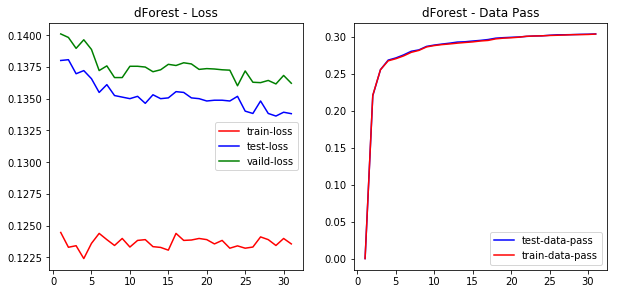

In [93]:

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)
   
ax = plt.subplot(gs[0, 0])
fig = plt.plot(range(1,32),[1-i for i in train_loss_lt[:31]], label="train-loss", color="red")
fig = plt.plot(range(1,32),[1-i for i in test_loss_lt[:31]], label="test-loss", color="blue")
fig = plt.plot(range(1,32),[1-i for i in vaild_loss_lt[:31]], label="vaild-loss", color="green")
plt.title('dForest - Loss')
plt.legend()

ax = plt.subplot(gs[0, 1])
fig = plt.plot(range(1,32),pass_data_rate_lt[:31], label="test-data-pass", color="blue")
fig = plt.plot(range(1,32),pass_data_rate_test_lt[:31], label="train-data-pass", color="red")
plt.title('dForest - Data Pass')
plt.legend()

plt.savefig("./logs/images/adult2-2.pdf", bbox_inches='tight')
plt.show()

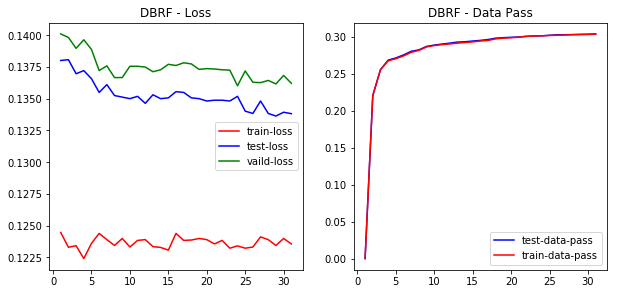

In [100]:

fig = plt.figure(figsize=(10,10))
gs = gridspec.GridSpec(2, 2)
   
ax = plt.subplot(gs[0, 0])
fig = plt.plot(range(1,32),[1-i for i in train_loss_lt[:31]], label="train-loss", color="red")
fig = plt.plot(range(1,32),[1-i for i in test_loss_lt[:31]], label="test-loss", color="blue")
fig = plt.plot(range(1,32),[1-i for i in vaild_loss_lt[:31]], label="vaild-loss", color="green")
plt.title('DBRF - Loss')
plt.legend()

ax = plt.subplot(gs[0, 1])
fig = plt.plot(range(1,32),pass_data_rate_lt[:31], label="test-data-pass", color="blue")
fig = plt.plot(range(1,32),pass_data_rate_test_lt[:31], label="train-data-pass", color="red")
plt.title('DBRF - Data Pass')
plt.legend()

plt.savefig("./logs/images/adult2-2.pdf", bbox_inches='tight')
plt.show()

In [94]:
0.866248748234138-0.86198636447392663

0.0042623837602113746

In [76]:
test_loss_lt[30]

0.866178748234138

In [58]:
print(train_loss_lt)
print(test_loss_lt)
print(vaild_loss_lt)
print(pass_data_rate_lt)

[0.8755446700039925, 0.8767117103283069, 0.8765888639783791, 0.8776023463652837, 0.8764045944534873, 0.8756180706980744, 0.8761094560977857, 0.876570129910015, 0.8760173213353398, 0.8766929762599429, 0.8761708792727496, 0.8761094560977857, 0.8766622646724609, 0.8767236878474248, 0.8769386689597986, 0.8756180706980744, 0.8761708792727496, 0.8761401676852677, 0.8760173213353398, 0.8761094560977857, 0.8764472835600873, 0.8761708792727496, 0.8767851110223888, 0.876600841497497, 0.8767851110223888, 0.8766929762599429, 0.875894474985412, 0.8761094560977857, 0.876570129910015, 0.8760173213353398, 0.8764472835600873, 0.876631553084979, 0.8766929762599429, 0.8767543994349067, 0.8770000921347625, 0.8759866097478579, 0.8761708792727496, 0.8753723779982188, 0.8757716286354842, 0.8759558981603759, 0.8765087067350511, 0.8764779951475692, 0.8757409170480022, 0.8759866097478579, 0.8767236878474248, 0.8759866097478579, 0.8760787445103038, 0.875925186572894, 0.8762630140351955, 0.875894474985412, 0.8759

In [28]:
len(list(range(31)))

31

In [29]:
len(vaild_loss_lt)

56

In [94]:
y_test

array([1, 0, 2, 1, 1, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1,
       2, 2, 1, 2])

In [95]:
y_test == df.predict(X_test)

array([ True,  True,  True,  True, False,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True], dtype=bool)

In [91]:
df.predict(X_test)

array([1, 0, 2, 1, 2, 0, 1, 2, 1, 1, 2, 0, 0, 0, 0, 1, 2, 1, 1, 2, 0, 2, 0,
       2, 2, 2, 2, 2, 0, 0, 0, 0, 1, 0, 0, 2, 1, 0, 0, 0, 2, 1, 1, 0, 0, 1,
       2, 2, 1, 2])

In [6]:
import EnhancedForest_multiclass
import DecomposerForest
import LogUtils
import AlgorithmUtils
import importlib
importlib.reload(DecomposerForest)
importlib.reload(LogUtils)
importlib.reload(EnhancedForest_multiclass)
importlib.reload(AlgorithmUtils)
np.seterr(divide='ignore', invalid='ignore')
import warnings
warnings.filterwarnings("ignore")

c:\program files\python36\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [7]:
from sklearn import metrics
def acc_metrix_mult(a, p):
#     print(p)
    return "acc", metrics.accuracy_score(a, p)

In [8]:
decoForest = DecomposerForest.DecomposerForest(X_train, y_train, X_test, y_test, num_class=3, flag="adult", isLRStacker=True)
decoForest.set_parameter(criterion="gini", dropout=None, min_samples_leaf=10)
decoForest.fit(n_estimators=200, kfold=3, feval=acc_metrix_mult)


2018-04-21 19:38:06 layer: 1
all data ('acc', 0.93999999999999995)
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
1 [p:0/np:0] 

2018-04-21 19:38:08 layer: 2
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 1.0)
pass test loss (0, 0)
pass test loss now (0, 1)
2 [p:0/np:50] 

2018-04-21 19:38:10 layer: 3
all data ('acc', 0.94999999999999996)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.94999999999999996)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.95999

all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-04-21 19:38:58 layer: 25
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-04-21 19:39:00 layer: 26
all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.92000000000000004)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.959999

all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.95999999999999996)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-04-21 19:39:47 layer: 48
all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.92000000000000004)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
48 [p:0/np:50] 

2018-04-21 19:39:49 layer: 49
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0

In [74]:
decoForest = DecomposerForest.DecomposerForest(X_train, y_train, X_test, y_test, num_class=3, flag="adult", isLRStacker=True)
decoForest.set_parameter(criterion="gini", dropout=None, min_samples_leaf=10)
decoForest.fit(n_estimators=200, kfold=3, feval=acc_metrix_mult)


2018-01-27 00:40:07 layer: 1
all data ('acc', 0.93999999999999995)
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
1 [p:0/np:0] 

2018-01-27 00:40:09 layer: 2
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 1.0)
pass test loss (0, 0)
pass test loss now (0, 1)
2 [p:0/np:50] 

2018-01-27 00:40:11 layer: 3
all data ('acc', 0.94999999999999996)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.94999999999999996)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.95999

all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-01-27 00:40:58 layer: 25
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-01-27 00:41:00 layer: 26
all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.92000000000000004)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.959999

all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.90000000000000002)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.95999999999999996)
pass test loss (0, 0)
pass test loss now (0, 1)
not pass

2018-01-27 00:41:47 layer: 48
all data ('acc', 0.93999999999999995)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93999999999999995)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.92000000000000004)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0.97999999999999998)
pass test loss (0, 0)
pass test loss now (0, 1)
48 [p:0/np:50] 

2018-01-27 00:41:49 layer: 49
all data ('acc', 0.93000000000000005)
[p:0/1:0|n:100/1:35] 
train loss ('acc', 0.93000000000000005)
pass train loss (0, 0)
pass train loss now (0, 1)
vaild loss ('acc', 0.91000000000000003)
pass vaild loss (0, 0)
pass vaild loss now (0, 1)
test loss ('acc', 0

In [75]:
np.max(np.array(decoForest.test_loss_lt)),list(enumerate(decoForest.test_loss_lt) )

(1.0,
 [(0, 0.97999999999999998),
  (1, 1.0),
  (2, 0.95999999999999996),
  (3, 0.95999999999999996),
  (4, 0.93999999999999995),
  (5, 0.93999999999999995),
  (6, 0.97999999999999998),
  (7, 1.0),
  (8, 0.93999999999999995),
  (9, 0.95999999999999996),
  (10, 0.95999999999999996),
  (11, 0.93999999999999995),
  (12, 0.95999999999999996),
  (13, 0.97999999999999998),
  (14, 0.95999999999999996),
  (15, 0.95999999999999996),
  (16, 0.93999999999999995),
  (17, 0.97999999999999998),
  (18, 0.93999999999999995),
  (19, 1.0),
  (20, 0.97999999999999998)])

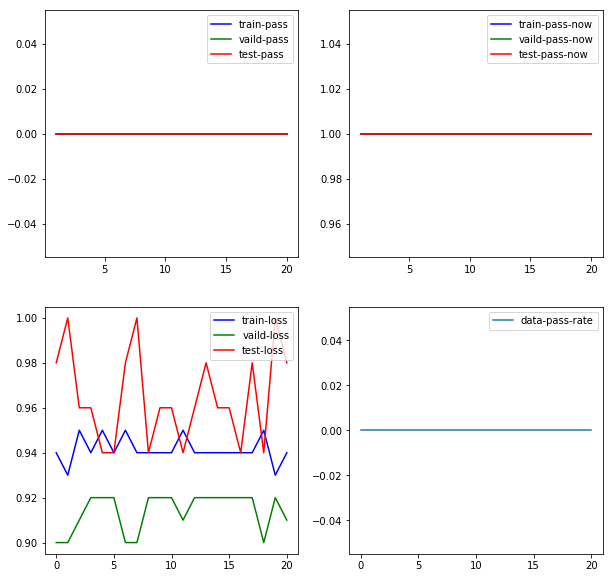

In [76]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,10))
x = range(len(decoForest.train_loss_lt))

plt.subplot(221)
plt.plot(x[1:],decoForest.pass_train_loss_lt[1:], label="train-pass", color="blue")
plt.plot(x[1:],decoForest.pass_vaild_loss_lt[1:], label="vaild-pass", color="green")
plt.plot(x[1:],decoForest.pass_test_loss_lt[1:], label="test-pass", color="red")
plt.legend()
plt.subplot(222)
plt.plot(x[1:],decoForest.pass_train_loss_lt_now[1:], label="train-pass-now", color="blue")
plt.plot(x[1:],decoForest.pass_vaild_loss_lt_now[1:], label="vaild-pass-now", color="green")
plt.plot(x[1:],decoForest.pass_test_loss_lt_now[1:], label="test-pass-now", color="red")
plt.legend()
plt.subplot(223)
plt.plot(x,decoForest.train_loss_lt, label="train-loss", color="blue")
plt.plot(x,decoForest.vaild_loss_lt, label="vaild-loss", color="green")
plt.plot(x,decoForest.test_loss_lt, label="test-loss", color="red")
plt.legend()
plt.subplot(224)
plt.plot(x,decoForest.pass_data_rate_lt[:], label="data-pass-rate")
plt.legend()

plt.show()

In [9]:
df = decoForest.enhancedDTree.estimator_list[1][0]
df

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=10, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=200, n_jobs=-1,
            oob_score=False, random_state=1024, verbose=0,
            warm_start=False)

Accuracy: 0.89 (+/- 0.03) [KNN]
Accuracy: 0.90 (+/- 0.04) [Random Forest]
Accuracy: 0.89 (+/- 0.03) [Naive Bayes]
Accuracy: 0.89 (+/- 0.04) [Stacking Classifier]


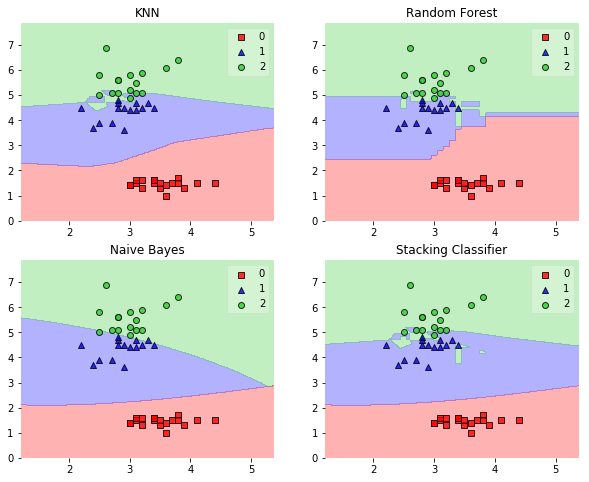

In [34]:
label = ['KNN', 'Random Forest', 'Naive Bayes', 'Stacking Classifier']
clf_list = [clf1, clf2, clf3, sclf]
    
fig = plt.figure(figsize=(10,8))
gs = gridspec.GridSpec(2, 2)
grid = itertools.product([0,1],repeat=2)

clf_cv_mean = []
clf_cv_std = []
for clf, label, grd in zip(clf_list, label, grid):
        
    scores = cross_val_score(clf, X_train, y_train, cv=3, scoring='accuracy')
    print("Accuracy: %.2f (+/- %.2f) [%s]" %(scores.mean(), scores.std(), label))
    clf_cv_mean.append(scores.mean())
    clf_cv_std.append(scores.std())
        
    clf.fit(X_train, y_train)
    ax = plt.subplot(gs[grd[0], grd[1]])
    fig = plot_decision_regions(X=X_test, y=y_test, clf=clf)
    plt.title(label)

plt.show()

In [32]:
grid[0]

TypeError: 'itertools.product' object is not subscriptable

The stacking ensemble is illustrated int the figure above. It consists of k-NN, Random Forest and Naive Bayes base classifiers whose predictions are combined by Lostic Regression as a meta-classifier. We can see the blending of decision boundaries achieved by the stacking classifier.

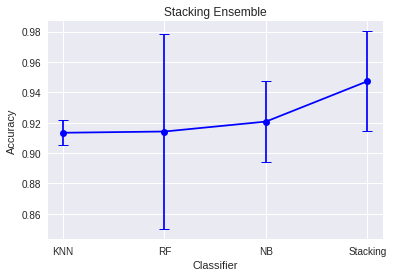

In [35]:
#plot classifier accuracy    
plt.figure()
(_, caps, _) = plt.errorbar(range(4), clf_cv_mean, yerr=clf_cv_std, c='blue', fmt='-o', capsize=5)
for cap in caps:
    cap.set_markeredgewidth(1)                                                                                                                                
plt.xticks(range(4), ['KNN', 'RF', 'NB', 'Stacking'])        
plt.ylabel('Accuracy'); plt.xlabel('Classifier'); plt.title('Stacking Ensemble');
plt.show()

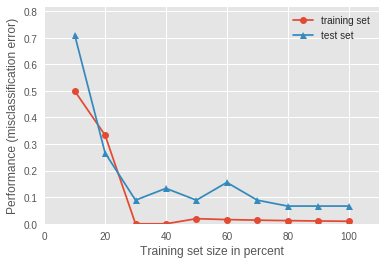

In [37]:
#plot learning curves
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
    
plt.figure()
plot_learning_curves(X_train, y_train, X_test, y_test, sclf, print_model=False, style='ggplot')
plt.show()

We can see that stacking achieves higher accuracy than individual classifiers and based on learning curves, it shows no signs of overfitting.